# Prompt engineering

In [1]:
import re
import string
import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# import other python files
from utils_benchmark import *
from utils import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
humans = pd.read_csv('./data_processed/humans_data_processed.csv')

# prompt 1: baseline
gpt_35_processed_p1 = pd.read_csv('./data_processed/prompt_1/gpt35_merged_343.csv')
gpt_4_processed_p1  = pd.read_csv('./data_processed/prompt_1/gpt4_merged_398.csv')

# prompt 2: wo_creative_constraint
gpt_35_processed_p2 = pd.read_csv('./data_processed/prompt_2/gpt35_merged_329.csv')
gpt_4_processed_p2  = pd.read_csv('./data_processed/prompt_2/gpt4_merged_372.csv')

# prompt 3: wo_length_constraint
gpt_35_processed_p3 = pd.read_csv('./data_processed/prompt_3/gpt35_merged_359.csv')
gpt_4_processed_p3 = pd.read_csv('./data_processed/prompt_3/gpt4_merged_391.csv')

# prompt 4: wo_persona
gpt_35_processed_p4 = pd.read_csv('./data_processed/prompt_4/gpt35_merged_363.csv')
gpt_4_processed_p4 = pd.read_csv('./data_processed/prompt_4/gpt4_merged_395.csv')

# prompt 5: wo_persona_and_context
gpt_35_processed_p5 = pd.read_csv('./data_processed/prompt_5/gpt35_merged_341.csv')
gpt_4_processed_p5 = pd.read_csv('./data_processed/prompt_5/gpt4_merged_375.csv')

# prompt 6: same humans: "What is a surprising use for...?"
gpt_35_processed_p6 = pd.read_csv('./data_processed/prompt_6/gpt35_merged_317.csv')
gpt_4_processed_p6 = pd.read_csv('./data_processed/prompt_6/gpt4_merged_393.csv')

# prompt 7: wo_creative_constraint_and_length_constraint
gpt_35_processed_p7 = pd.read_csv('./data_processed/prompt_7/gpt35_merged_325.csv')
gpt_4_processed_p7 = pd.read_csv('./data_processed/prompt_7/gpt4_merged_386.csv')

# prompt 5 fs max
gpt_35_processed_5_fs_max = pd.read_csv('./data_processed/prompt_fs_1_max/gpt35_merged_5_fs_330.csv')
gpt_4_processed_5_fs_max = pd.read_csv('./data_processed/prompt_fs_1_max/gpt4_merged_5_fs_392.csv')

# prompt 5 fs random
gpt_35_processed_5_fs_random = pd.read_csv('./data_processed/prompt_fs_1_random/gpt35_merged_5_fs_344.csv')
gpt_4_processed_5_fs_random = pd.read_csv('./data_processed/prompt_fs_1_random/gpt4_merged_5_fs_393.csv')

# prompt 5 fs random with scores 
gpt_35_processed_5_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt35_merged_5_fs_339.csv')
gpt_4_processed_5_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt4_merged_5_fs_392.csv')

# prompt 10 fs random with scores 
gpt_35_processed_10_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt35_merged_10_fs_316.csv')
gpt_4_processed_10_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt4_merged_10_fs_393.csv')

# prompt 20 fs random with scores 
gpt_35_processed_20_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt35_merged_20_fs_275.csv')
gpt_4_processed_20_fs_scores = pd.read_csv('./data_processed/prompt_fs_2/gpt4_merged_20_fs_382.csv')

## Comparison 0-shot prompting

In [12]:
# combine all data
combined_data = pd.concat([
    humans.assign(prompt_type='Humans'),
    gpt_35_processed_p1.assign(prompt_type='P1'),
    gpt_35_processed_p2.assign(prompt_type='P2'),
    gpt_35_processed_p3.assign(prompt_type='P3'),
    gpt_35_processed_p4.assign(prompt_type='P4'),
    gpt_35_processed_p5.assign(prompt_type='P5'),
    gpt_35_processed_p6.assign(prompt_type='P6'),
    gpt_35_processed_p7.assign(prompt_type='P7'),
])

combined_data.head()

,prompt,response,originality,elaboration,dissimilarity,elaboration_SW,flexibility,flexibility_augmented,prompt_type
0,brick,strength tester (punching),2.7,5.0,0.339320,5,0,0.000000,Humans
1,brick,art,2.1,1.0,0.410352,1,1,0.761229,Humans
2,brick,pencil holder,2.1,2.0,0.311034,2,1,0.923506,Humans
3,brick,writing utensil,2.1,2.0,0.296534,2,0,0.000000,Humans
4,brick,earrings,2.2,1.0,0.402154,1,0,0.000000,Humans


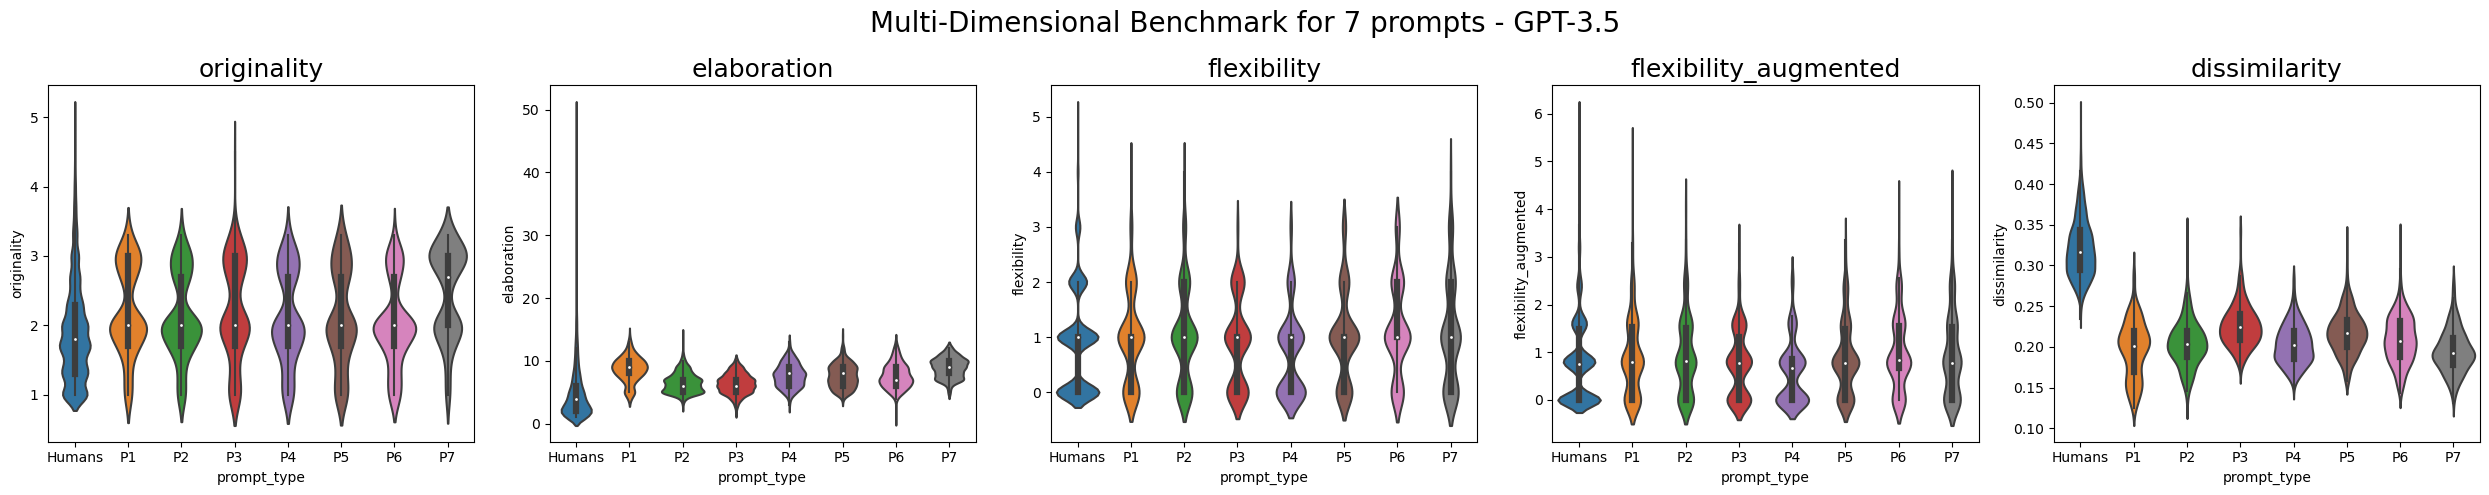

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, feat in enumerate(['originality', 'elaboration', 'flexibility', 'flexibility_augmented', 'dissimilarity']):
    sns.violinplot(x='prompt_type', y=feat, data=combined_data, ax=axs[i])
    axs[i].set_title(feat, fontsize = 18)
    #axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
plt.suptitle("Multi-Dimensional Benchmark for 7 prompts - GPT-3.5", fontsize = 20)
plt.tight_layout()
plt.show()

**Stastistical analysis**

In [14]:
# checking the normality of the distributions
from scipy.stats import shapiro

# Iterate over unique "Run" values
for prompt in combined_data['prompt_type'].unique():
    # Filter the DataFrame for the current "Run" value
    df_prompt_type = combined_data[combined_data['prompt_type'] == prompt]
    
    # Perform Shapiro-Wilk test for normality on the 'elaboration' column
    shapiro_stat, shapiro_p_value = shapiro(df_prompt_type['dissimilarity'])
    
    # Output the results
    print(f"Prompt {prompt}: Shapiro-Wilk statistic = {shapiro_stat}, p-value = {shapiro_p_value}")

Prompt Humans: Shapiro-Wilk statistic = 0.9748785495758057, p-value = 5.965537757400395e-40
Prompt P1: Shapiro-Wilk statistic = 0.9782193899154663, p-value = 4.673304647440091e-05
Prompt P2: Shapiro-Wilk statistic = 0.9813892841339111, p-value = 0.00028983381344005466
Prompt P3: Shapiro-Wilk statistic = 0.9561808109283447, p-value = 7.283985858919095e-09
Prompt P4: Shapiro-Wilk statistic = 0.9813240766525269, p-value = 0.00011994061060249805
Prompt P5: Shapiro-Wilk statistic = 0.9870373010635376, p-value = 0.0038156246300786734
Prompt P6: Shapiro-Wilk statistic = 0.9895540475845337, p-value = 0.022863924503326416
Prompt P7: Shapiro-Wilk statistic = 0.9842270016670227, p-value = 0.0012494121911004186


c:\Users\Maxime\anaconda3\envs\ada\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [15]:
import scipy.stats as stats
from scipy.stats import mannwhitneyu

# Perform pairwise t-tests between each pair of runs
prompt_labels = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']

for feat in ['originality', 'elaboration', 'flexibility', 'flexibility_augmented', 'dissimilarity']:
    print("\n\n",feat)
    for prompt_type in prompt_labels:
        # Extract elaboration scores for the two runs
        feature_PN = combined_data[combined_data['prompt_type'] == prompt1][feat]
        
        # Perform t-test
        #t_stat, p_value = stats.ttest_ind(elaboration_run1, elaboration_run2)
        # Perform Perform Mann-Whitney U test
        mwu_statistic, mwu_p_value = mannwhitneyu(combined_data[combined_data['prompt_type'] == 'Humans'][feat], feature_PN, alternative='two-sided')
        
        print(f"Humans vs. Prompt {prompt_type}: Mann-Whitney U statistic = {mwu_statistic}, p-value = {mwu_p_value}")



 originality
Humans vs. Prompt P1: Mann-Whitney U statistic = 1490816.0, p-value = 1.146593522543608e-05
Humans vs. Prompt P2: Mann-Whitney U statistic = 1490816.0, p-value = 1.146593522543608e-05
Humans vs. Prompt P3: Mann-Whitney U statistic = 1490816.0, p-value = 1.146593522543608e-05
Humans vs. Prompt P4: Mann-Whitney U statistic = 1490816.0, p-value = 1.146593522543608e-05
Humans vs. Prompt P5: Mann-Whitney U statistic = 1490816.0, p-value = 1.146593522543608e-05
Humans vs. Prompt P6: Mann-Whitney U statistic = 1490816.0, p-value = 1.146593522543608e-05
Humans vs. Prompt P7: Mann-Whitney U statistic = 1490816.0, p-value = 1.146593522543608e-05


 elaboration
Humans vs. Prompt P1: Mann-Whitney U statistic = 691506.5, p-value = 3.013466942295495e-76
Humans vs. Prompt P2: Mann-Whitney U statistic = 691506.5, p-value = 3.013466942295495e-76
Humans vs. Prompt P3: Mann-Whitney U statistic = 691506.5, p-value = 3.013466942295495e-76
Humans vs. Prompt P4: Mann-Whitney U statistic = 6915

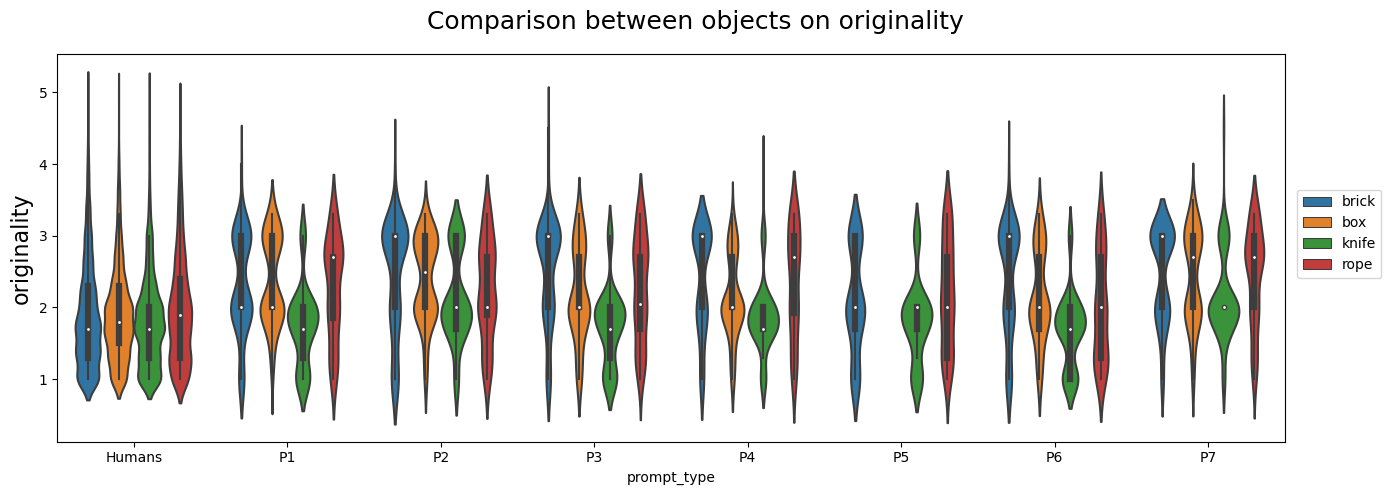

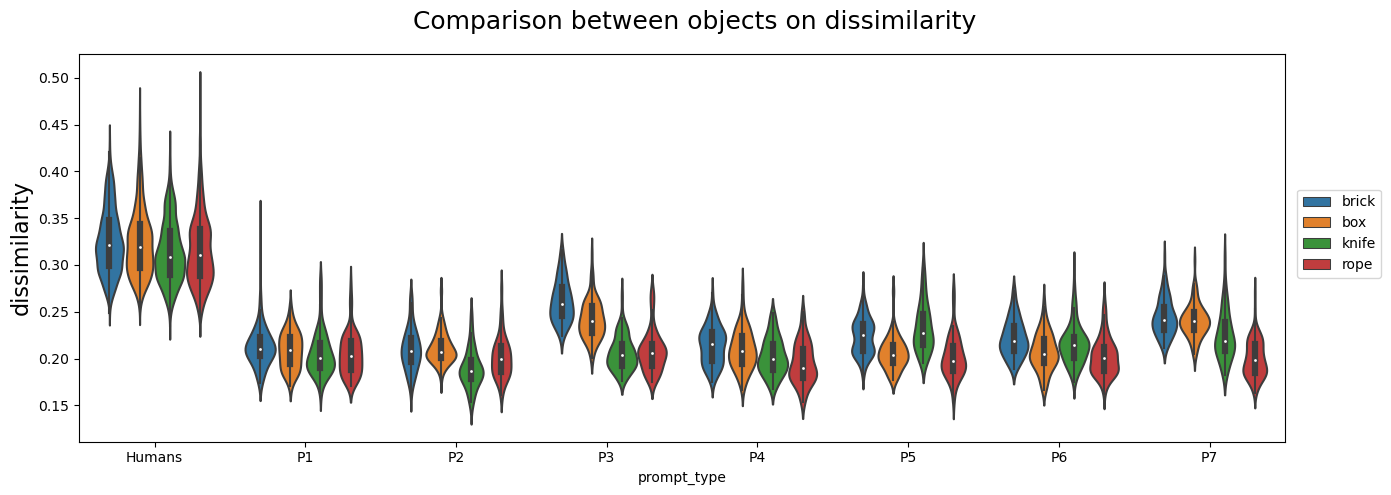

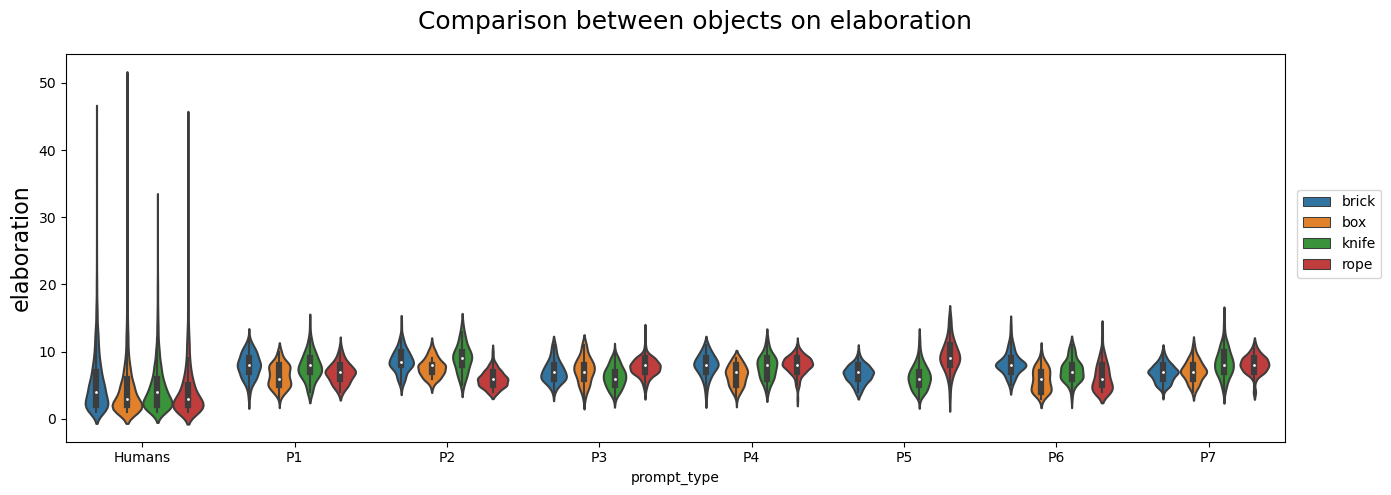

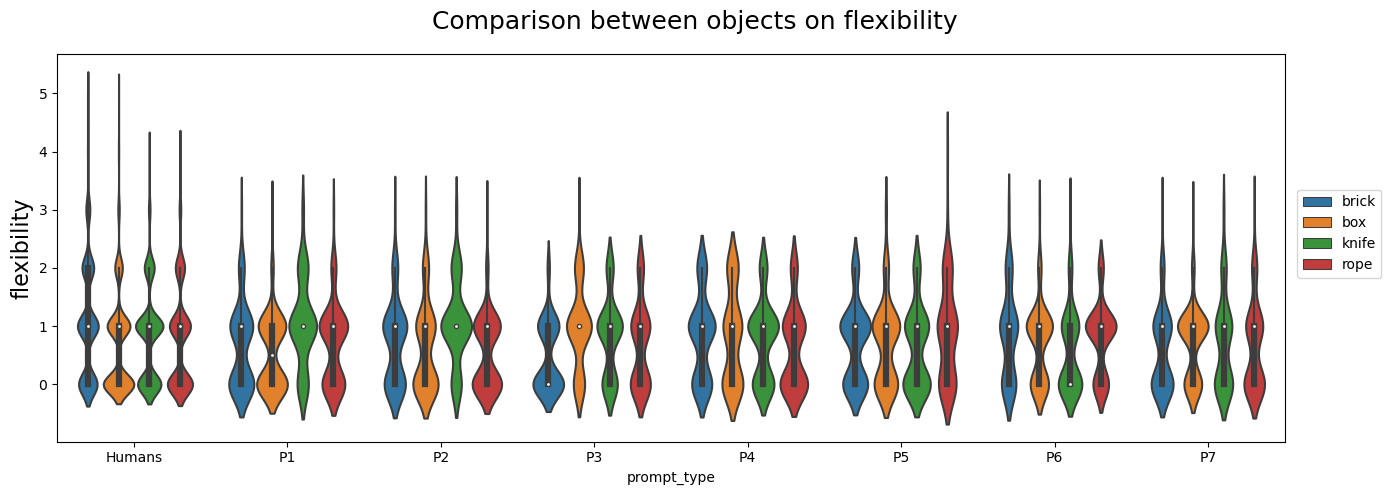

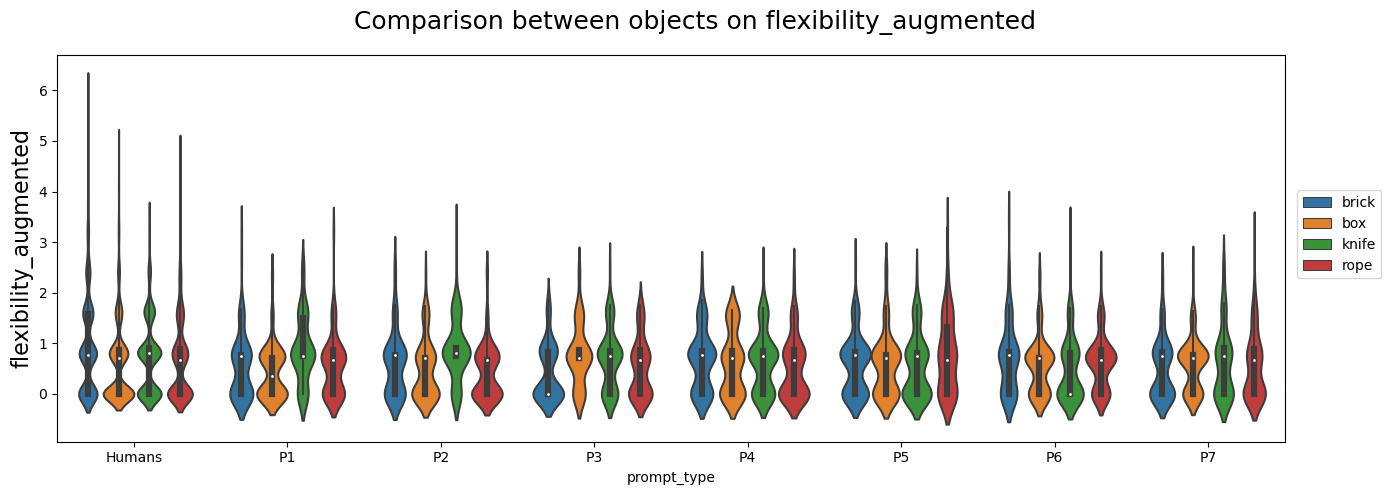

In [77]:
# Comparison analysis between objects
plot_per_object(type = "violinplot", features = ["originality", "dissimilarity", "elaboration", "flexibility", "flexibility_augmented"], combined_data = combined_data)

## Comparison Few-shot prompting

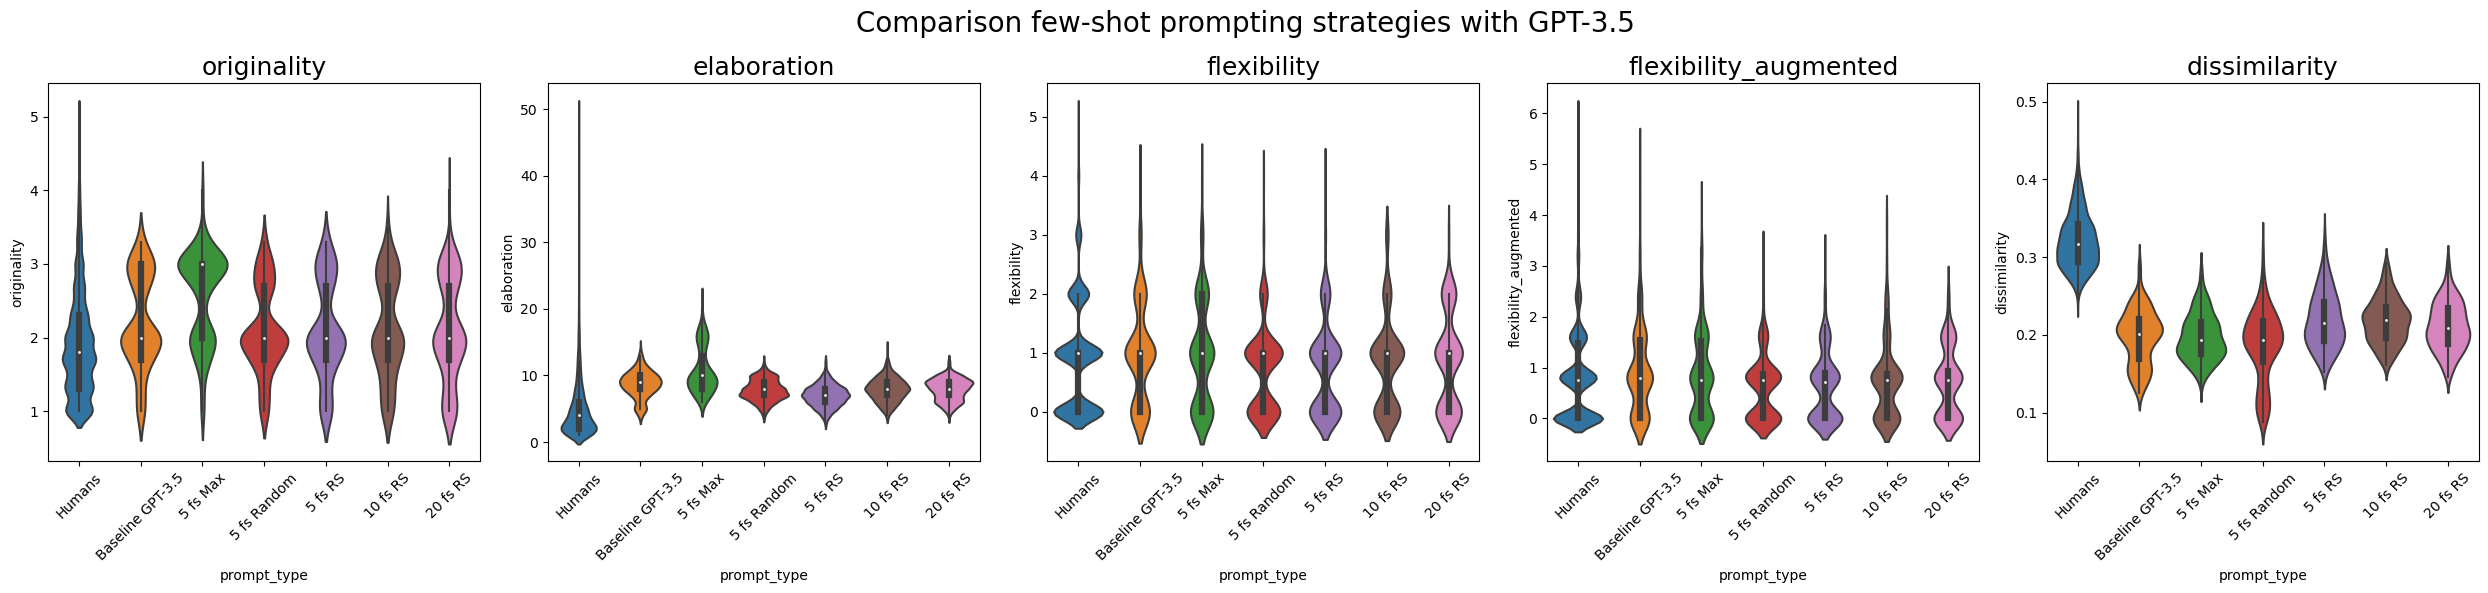

In [17]:
# comparison of few shot prompting

# combine all data for few shot prompting: baseline = prompt 1
combined_data_few_shot = pd.concat([
    humans.assign(prompt_type='Humans'),
    gpt_35_processed_p1.assign(prompt_type='Baseline GPT-3.5'),
    gpt_35_processed_5_fs_max.assign(prompt_type='5 fs Max'),
    gpt_35_processed_5_fs_random.assign(prompt_type='5 fs Random'),
    gpt_35_processed_5_fs_scores.assign(prompt_type='5 fs RS'),
    gpt_35_processed_10_fs_scores.assign(prompt_type='10 fs RS'),
    gpt_35_processed_20_fs_scores.assign(prompt_type='20 fs RS'),
])

fig, axs = plt.subplots(1, 5, figsize=(25, 6))
for i, feat in enumerate(['originality', 'elaboration', 'flexibility', 'flexibility_augmented', 'dissimilarity']):
    sns.violinplot(x='prompt_type', y=feat, data=combined_data_few_shot, ax=axs[i])
    axs[i].set_title(feat, fontsize = 18)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
plt.suptitle("Comparison few-shot prompting strategies with GPT-3.5", fontsize = 20)
plt.tight_layout()
plt.show()

**Number of samples with 0 flexibility score**

In [15]:
LLM_only = combined_data_few_shot[combined_data_few_shot['prompt_type'] != 'Humans']
for dataset in LLM_only['prompt_type'].unique():
    LLM_dataset = LLM_only[LLM_only['prompt_type'] == dataset]
    nb_0 = len(LLM_dataset[LLM_dataset['flexibility'] == 0])
    print(f"{dataset}: {nb_0} with missing flexibility values, {np.round(100*nb_0/len(LLM_dataset),2)}% missing values")

Baseline GPT-4: 158 with missing flexibility values, 39.7% missing values
5 fs Max: 184 with missing flexibility values, 46.94% missing values
5 fs Random: 233 with missing flexibility values, 59.29% missing values
5 fs RS: 226 with missing flexibility values, 57.65% missing values
10 fs RS: 217 with missing flexibility values, 55.22% missing values
20 fs RS: 199 with missing flexibility values, 52.09% missing values


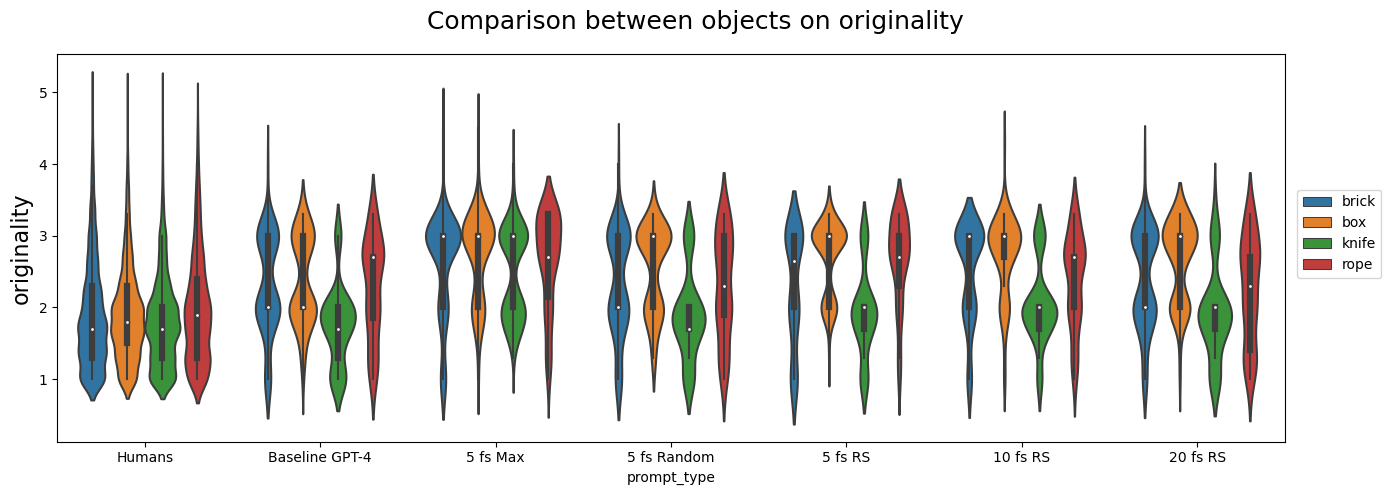

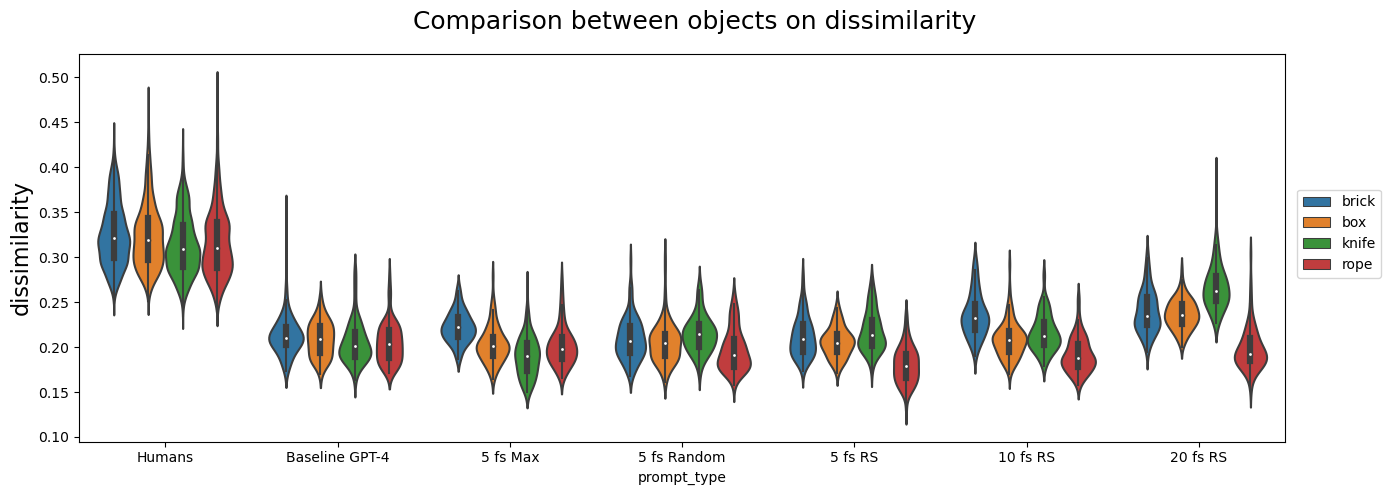

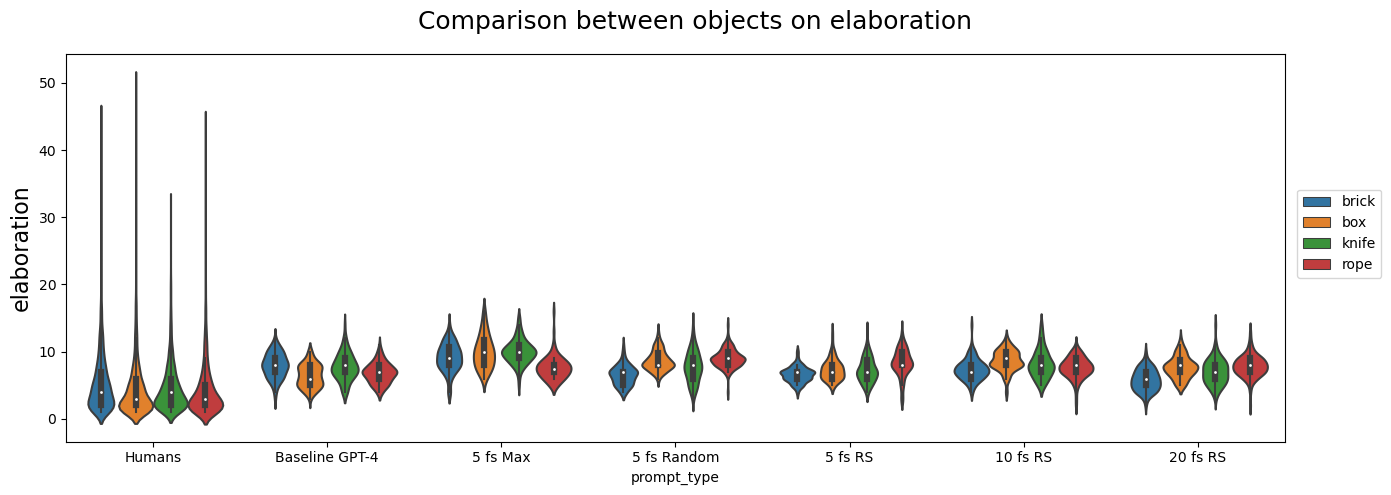

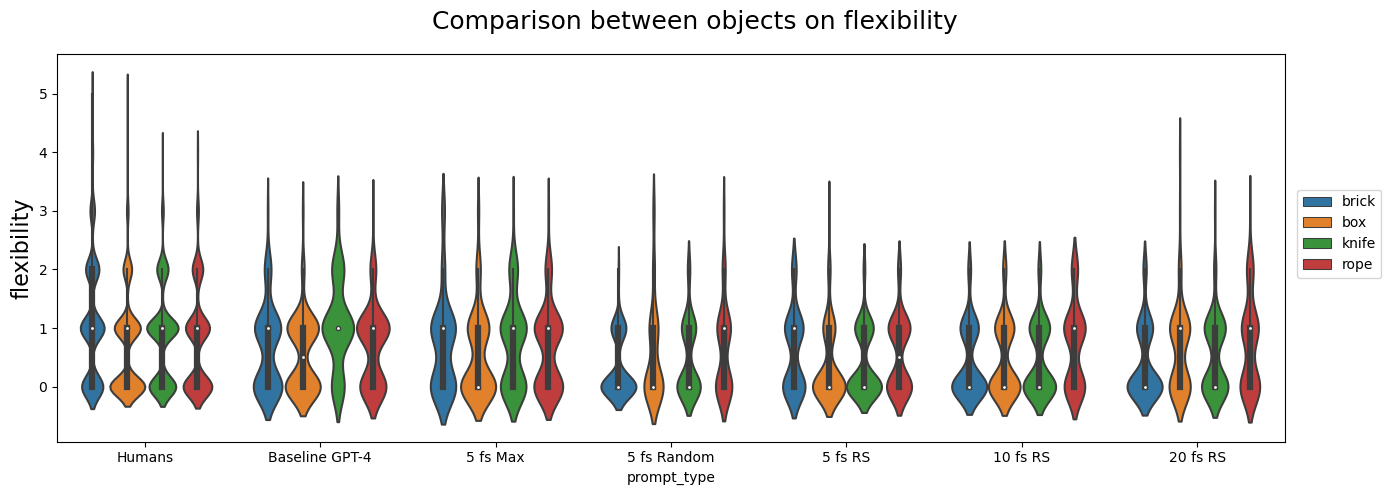

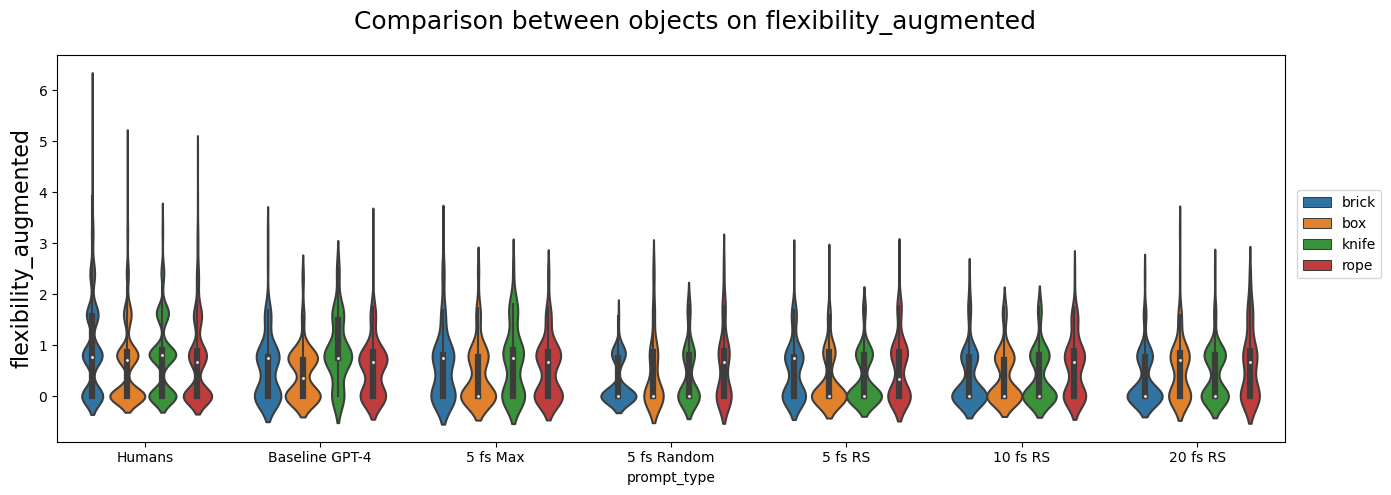

In [14]:
# Comparison analysis between objects
plot_per_object(type = "violinplot", features = ["originality", "dissimilarity", "elaboration", "flexibility", "flexibility_augmented"], combined_data = combined_data_few_shot)

# Radar charts

set to 4 models now in utils_benchmark.py

['Humans' 'P1' 'P3' '5 fs Max']


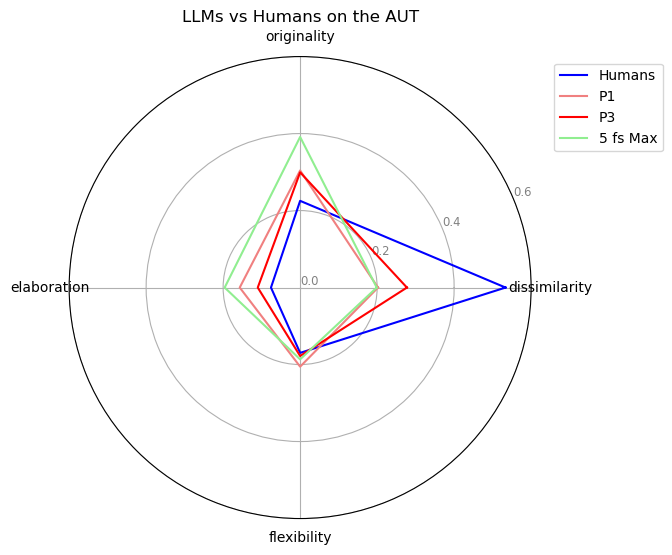

In [10]:
combined_data_radar_chart = pd.concat([
    humans.assign(prompt_type='Humans'),
    gpt_35_processed_p1.assign(prompt_type='P1'),
    gpt_35_processed_p3.assign(prompt_type='P3'),
    gpt_35_processed_5_fs_max.assign(prompt_type='5 fs Max'),
])
combined_data_radar_chart.head()

# normalization
combined_data_radar_chart_norm = normalization_1(combined_data_radar_chart, check_norm = False)
print(combined_data_radar_chart_norm['prompt_type'].unique())
combined_data_radar_chart_norm.head()

features = ['prompt', 'dissimilarity', 'originality', 'elaboration', 'flexibility']

humans_norm = combined_data_radar_chart_norm[combined_data_radar_chart_norm['prompt_type'] == 'Humans']
gpt_35_norm_p1 = combined_data_radar_chart_norm[combined_data_radar_chart_norm['prompt_type'] == 'P1']
gpt_35_norm_p3 = combined_data_radar_chart_norm[combined_data_radar_chart_norm['prompt_type'] == 'P3']
gpt_35_norm_5_fs_max = combined_data_radar_chart_norm[combined_data_radar_chart_norm['prompt_type'] == '5 fs Max']


# List of dataframes and corresponding titles
dataframes = [humans_norm[features], gpt_35_norm_p1[features], gpt_35_norm_p3[features], gpt_35_norm_5_fs_max[features]]#, gpt_35_norm_p5[features], gpt_35_norm_p6[features]]
titles = ['Humans', 'P1', 'P3', '5 fs Max']#, 'GPT-3.5 prompt 5', 'GPT-3.5 prompt 6']
colors = ['blue', 'lightcoral', 'red', 'lightgreen', 'green']

# Plot radar chart for multiple dataframes
plot_radar_chart(dataframes, titles, colors, avg_per_object = True)

### Radar charts per object

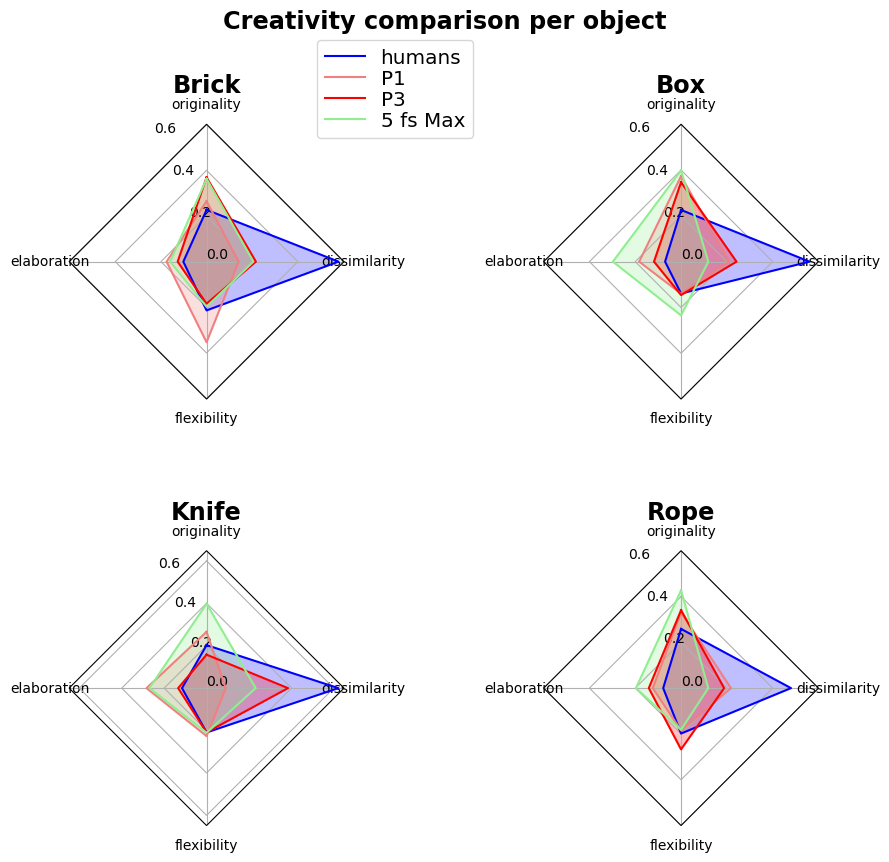

In [8]:
### PARAMETERS ###
data_dict = {"humans": humans, "P1": gpt_35_processed_p1, "P3": gpt_35_processed_p3, "5 fs Max": gpt_35_processed_5_fs_max}
features = ["originality", "elaboration", "flexibility", "dissimilarity"]
#################

objects = ["brick", "box", "knife", "rope"]
normalized_data = prepare_data_for_radar_chart_per_object(data_dict, objects)
brick_norm, box_norm, knife_norm, rope_norm = normalized_data["brick_norm"], normalized_data["box_norm"], normalized_data["knife_norm"], normalized_data["rope_norm"]
dataframes = [brick_norm, box_norm, knife_norm, rope_norm]
colors = ['blue', 'lightcoral', 'red', 'lightgreen']#, 'green']
titles = data_dict.keys()

radar_charts_per_object(brick_norm, box_norm, knife_norm, rope_norm, features, model_names = list(data_dict.keys()), colors = colors)

# Multi-variate analysis

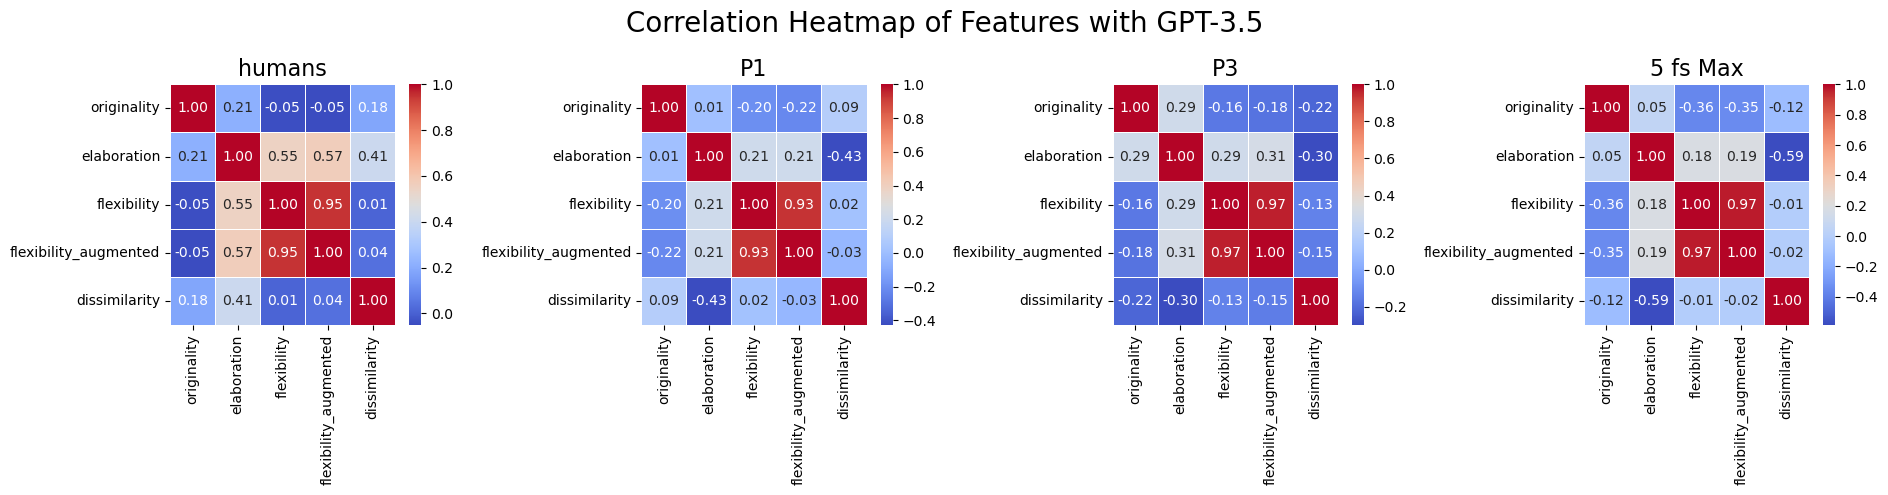

In [43]:
# correlation between dimensions
data_dict = {"humans": humans, "P1": gpt_35_processed_p1, "P3": gpt_35_processed_p3, "5 fs Max": gpt_35_processed_5_fs_max}

features = ['originality', 'elaboration', 'flexibility', 'flexibility_augmented', 'dissimilarity']
fig, axs = plt.subplots(1, len(data_dict), figsize=(19, 5))
i = 0
for name, df in data_dict.items():
    corr_matrix = df[features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax = axs[i])
    axs[i].set_title(name, fontsize = 16)
    axs[i].tick_params(axis = 'y', rotation = 360)
    i += 1
plt.suptitle('Correlation Heatmap of Features with GPT-3.5', fontsize = 20)
plt.tight_layout()
plt.show()

0.21353032154843288


c:\Users\Maxime\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


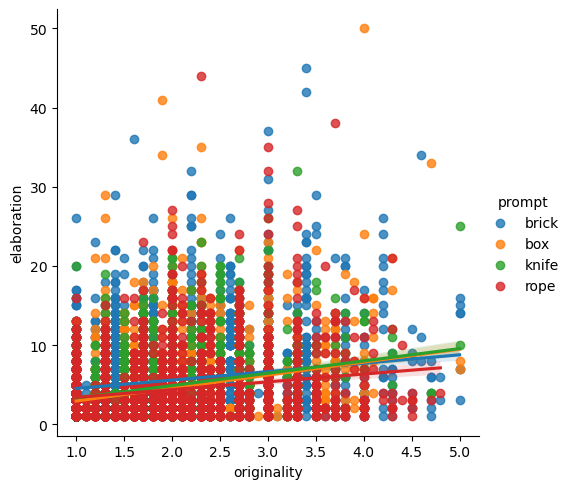

In [44]:
print(humans['originality'].corr(humans['elaboration']))
sns.lmplot(x='originality', y='elaboration', data=humans, hue = 'prompt')
plt.show()

In [48]:
humans_ocsai = pd.read_csv("./../data/humans_top4_objects_eval_ocsai_1098.csv")
print(len(humans_ocsai))
print(humans_ocsai['prompt'].value_counts())
humans_ocsai.head()

1098
prompt
brick    407
box      285
knife    204
rope     202
Name: count, dtype: int64


,prompt,response,originality,elaboration,originality_ocsai
0,brick,breaking into someone's house,1.5,4,1.0
1,knife,carving a tree,1.3,3,1.0
2,brick,as a subject in a photo,3.0,6,2.0
3,box,keep a baby animal in,1.7,5,1.3
4,brick,use as part of a design in a landscape,1.0,9,1.0


c:\Users\Maxime\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


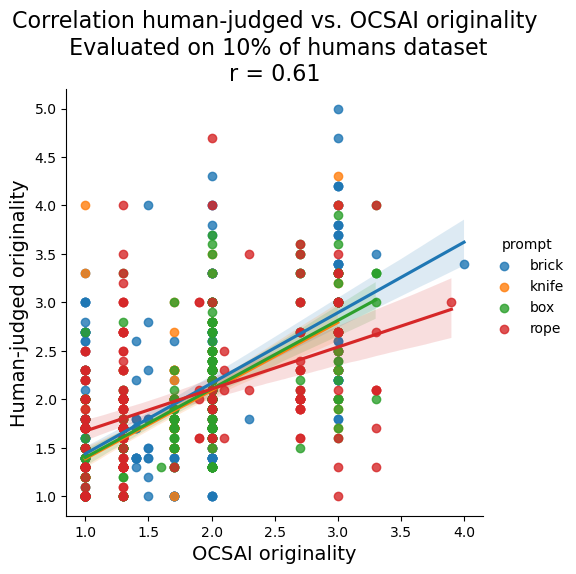

In [61]:
r = humans_ocsai['originality'].corr(humans_ocsai['originality_ocsai'])
sns.lmplot(x='originality_ocsai', y='originality', data=humans_ocsai, hue = 'prompt')
plt.title(f"Correlation human-judged vs. OCSAI originality\n Evaluated on 10% of humans dataset\nr = {r.round(2)}", fontsize = 16)
plt.xlabel("OCSAI originality", fontsize = 14)
plt.ylabel("Human-judged originality", fontsize = 14)
plt.show()